# YOUR PROJECT TITLE

> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **data analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code
> 1. The `dataproject.py` file includes a function which can be used multiple times in this notebook.

Imports and set magics:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from matplotlib_venn import venn2


# autoreload modules when code is run
%load_ext autoreload
%autoreload 2
%pip install pandas-datareader

# user written modules
import dataproject

import pandas_datareader 
import datetime


Note: you may need to restart the kernel to use updated packages.


# Read and clean data

Import your data, either through an API or manually, and load it. 

In [2]:
#Name/link to data in FRED 

#CPI data (Growth rate previous period, Not Seasonally Adjusted)
CPI_CAN = 'CPALTT01CAA657N'
CPI_USA = 'CPALTT01USA659N'
CPI_UK = 'CPALTT01GBA659N'

# Exchange rate 
EX_CAN = 'AEXCAUS' #(Canadian Dollars to One U.S. Dollar, Not Seasonally Adjusted)
EX_UK = 'AEXUSUK' #(U.S. Dollars to One U.K. Pound Sterling, Not Seasonally Adjusted)



In [3]:
# Need first to encode dates in a python friendly to specify the length of the desired time period. 
# Use the datetime module - it is the general way to handle dates in python. 
start = datetime.datetime(1990,1,1)
end = datetime.datetime(2020,1,1)
timespan = end - start # We can investigate the precise time span by just subtracting to time variables.
print('total number of days:', timespan.days) # The timespan object has a days attribute.

total number of days: 10957


In [4]:
# Call the FRED api using pandas_datareader 
inflation = pandas_datareader.data.DataReader([CPI_USA, CPI_UK, CPI_CAN], 'fred', start, end)
inflation = inflation.rename(columns = {'CPALTT01USA659N':'CPI_USA','CPALTT01GBA659N':'CPI_CA','CPALTT01CAA657N':'CPI_UK'})
inflation.head(31)

,CPI_USA,CPI_CA,CPI_UK
DATE,,,
1990-01-01,5.397956,8.0,4.780477
1991-01-01,4.234964,7.5,5.625864
1992-01-01,3.028820,4.6,1.490133
1993-01-01,2.951657,2.6,1.865079
1994-01-01,2.607442,2.2,0.165563
1995-01-01,2.805420,2.7,2.148760
1996-01-01,2.931204,2.9,1.570531
1997-01-01,2.337690,2.2,1.621216
1998-01-01,1.552279,1.8,0.995942


In [5]:
# Call the FRED api using pandas_datareader 
exchange = pandas_datareader.data.DataReader([EX_UK, EX_CAN], 'fred', start, end)
exchange = exchange.rename(columns = {'AEXUSUK':'USUK_EX','AEXCAUS':'CAUS_EX'})
exchange.head(31)

,USUK_EX,CAUS_EX
DATE,,
1990-01-01,1.7841,1.1668
1991-01-01,1.7674,1.1460
1992-01-01,1.7663,1.2085
1993-01-01,1.5016,1.2902
1994-01-01,1.5319,1.3664
1995-01-01,1.5785,1.3725
1996-01-01,1.5607,1.3638
1997-01-01,1.6376,1.3849
1998-01-01,1.6573,1.4836


## Explore each data set

In order to be able to **explore the raw data**, you may provide **static** and **interactive plots** to show important developments 

**Interactive plot** :

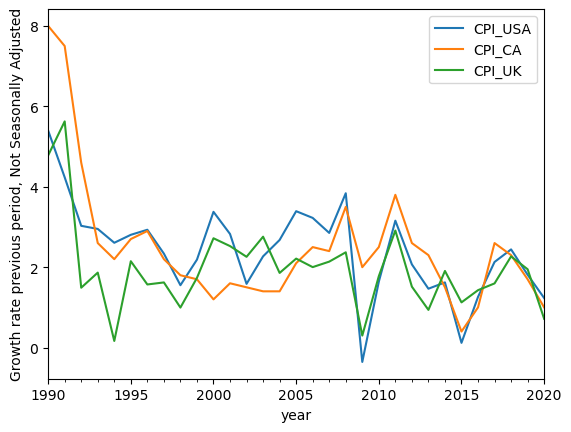

In [6]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

# Now we are just plotting directly from the pandas dataframe. Still using matplotlib under the hood.
inflation.plot(ax=ax)

ax.legend(frameon=True)
ax.set_xlabel('year')
ax.set_ylabel('Growth rate previous period, Not Seasonally Adjusted');

from jeppe

In [7]:
def plot_func():
    # Function that operates on data set
    pass

widgets.interact(plot_func, 
    # Let the widget interact with data through plot_func()    
); 


interactive(children=(Output(),), _dom_classes=('widget-interact',))

Explain what you see when moving elements of the interactive plot around. 

# Merge data sets

Now you create combinations of your loaded data sets. Remember the illustration of a (inner) **merge**:

In [13]:
ppp = pd.merge(inflation, exchange, how = 'outer', on = ['DATE']);
ppp['CA_pct_dif_from_USA_CPI'] = ((ppp.CPI_CA-ppp.CPI_USA) / ppp.CPI_USA) * 100 # the pct. difference between inflation in canada and USA
ppp['UK_pct_dif_from_USA_CPI'] = ((ppp.CPI_UK-ppp.CPI_USA) / ppp.CPI_USA) * 100 # the pct. difference between inflation in UK and USA
ppp['USUK_EX_DIF'] = (ppp['USUK_EX'].diff() / ppp['USUK_EX'].shift(1)) * 100
ppp.head(31)

,CPI_USA,CPI_CA,CPI_UK,USUK_EX,CAUS_EX,CA_pct_dif_from_USA_CPI,UK_pct_dif_from_USA_CPI,USUK_EX_DIF
DATE,,,,,,,,
1990-01-01,5.397956,8.0,4.780477,1.7841,1.1668,48.204234,-11.439135,NaN
1991-01-01,4.234964,7.5,5.625864,1.7674,1.1460,77.097139,32.843258,-0.936046
1992-01-01,3.028820,4.6,1.490133,1.7663,1.2085,51.874343,-50.801531,-0.062238
1993-01-01,2.951657,2.6,1.865079,1.5016,1.2902,-11.913883,-36.812462,-14.986129
1994-01-01,2.607442,2.2,0.165563,1.5319,1.3664,-15.626106,-93.650369,2.017848
1995-01-01,2.805420,2.7,2.148760,1.5785,1.3725,-3.757715,-23.406814,3.041974
1996-01-01,2.931204,2.9,1.570531,1.5607,1.3638,-1.064552,-46.420276,-1.127653
1997-01-01,2.337690,2.2,1.621216,1.6376,1.3849,-5.890000,-30.648785,4.927276
1998-01-01,1.552279,1.8,0.995942,1.6573,1.4836,15.958528,-35.839988,1.202980


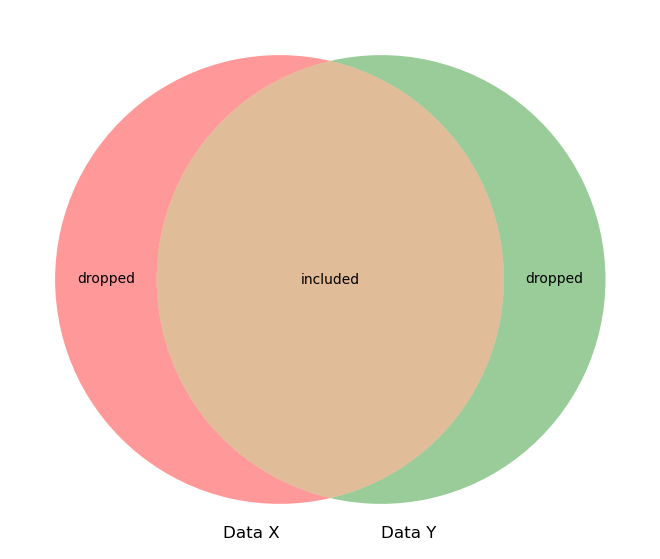

In [9]:
plt.figure(figsize=(15,7))
v = venn2(subsets = (4, 4, 10), set_labels = ('Data X', 'Data Y'))
v.get_label_by_id('100').set_text('dropped')
v.get_label_by_id('010').set_text('dropped' )
v.get_label_by_id('110').set_text('included')
plt.show()

Here we are dropping elements from both data set X and data set Y. A left join would keep all observations in data X intact and subset only from Y. 

Make sure that your resulting data sets have the correct number of rows and columns. That is, be clear about which observations are thrown away. 

**Note:** Don't make Venn diagrams in your own data project. It is just for exposition. 

# Analysis

To get a quick overview of the data, we show some **summary statistics** on a meaningful aggregation. 

MAKE FURTHER ANALYSIS. EXPLAIN THE CODE BRIEFLY AND SUMMARIZE THE RESULTS.

# Conclusion

ADD CONCISE CONLUSION.